In [1]:
'''Graded characters in the regular block O_0.
Note: Notation is dominant: L(e) is finite dimensional, Delta(e) is projective, Delta(w0) = L(w0), ...'''


W = WeylGroup("B4", prefix="s")
[s1,s2,s3,s4] = W.simple_reflections()

##################################################################################

n = rank(W)
w0 = W.long_element()
e = W(1)


####### Kazhdan-Lusztig polynomials ##########################

# A faster implementation of KL-polynomials (using the optional package Coxeter 3) is given by this
# Fokko Ducloux’s Coxeter3 C++ library.

# Had to install it: I just typed "sage -i coxeter3" in the terminal.

# It seems that one can direcly coerce from WeylGroup to CoxeterGroup and vice versa.
# I will therefore use CoxeterGroup to calculate KL-polynomials, but for all other Bruhat business I will use WeylGroup.

R.<q> = LaurentPolynomialRing(QQ)

KL = KazhdanLusztigPolynomial(W,q)  # KL-polynomials implemented in standard Sage way
# http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/kazhdan_lusztig.html


CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")

def KLP(x,y):
    '''Returns the KL-polynomial, implemented in "Coxeter3" package by Fokko du Cloux.
    http://math.univ-lyon1.fr/~ducloux/coxeter/coxeter3/english/coxeter3_e.html'''
    
    if x not in W:
        x = convert_from_123(x)
    if y not in W:
        y = convert_from_123(y)
    
    return CoxeterPackage.kazhdan_lusztig_polynomial(CoxeterPackage(x), CoxeterPackage(y))
    # If "coxeter3" is not installed, remove the line 'CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")'
    # and in this function return KL.P(x,y)

#Point:
#    - standard Sage way: KL.P(x,y)
#    - faster way: KLP(x,y) 


def mu(w,x):
    '''Returns the KL mu-function with arguments w,x.
    By Humphrey's BGG book p. 175 and p. 169, for w<x we have:
    mu(x,w) = mu(w0*w,w0*x),
    mu(w,x) = dim Exit^1 (L_w,L_x) = dim Exit^1(L_x,L_w) = dim Exit^1(Delta_x,L_w).'''

    if w not in W:
        w = convert_from_123(w)
    if x not in W:
        x = convert_from_123(x)
        
    if w.bruhat_le(x):
        poly_dict = KLP(w,x).dict()       
        j = (x.length()-w.length()-1)/2 
        if j not in poly_dict.keys():
            return 0
        return poly_dict[j]

    return 0


def dimExt(i,y,w):  
    '''Returns dimExt^i(Delta(y),L(w)).'''
    
    y = y*w0                               
    w = w*w0   
    poly_dict = KLP(y,w).dict()       
    j = (w.length()-y.length()-i)/2 
    if j not in poly_dict.keys():
        return 0
    return poly_dict[j]


def mult_Delta_L(y,w):
    '''Returns the Jordan-Holder multiplicity [Delta(y),L(w)] in O_0.
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.'''
      
    return KLP(y,w)(1)               


def mult_graded_Delta_L(w,k,x):
    '''Returns the graded Jordan-Holder multiplicity [Delta(w) shifted by k,L(x)].
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.''' 

    l_wx = x.length() - w.length()
    
    i = (l_wx-k)
    if i<0 or i%2!=0:
        return 0
    i = i/2
    
    KL_wx = KLP(w, x).dict()
    if i not in KL_wx.keys():
        return 0
    
    return KL_wx[i]


def earliest_occurence(x):
    '''Returns the smallest non-negative k such that L(x) occurs in Delta(e) at level k.
    To be used later in Lusztig's a function.'''
      
    for k in range(x.length()+1):
        
        if mult_graded_Delta_L(e,k,x) > 0:
            return k
    

def w0_(Sigma):
    '''Returns the longest element of the parabolic subgroup defined by Sigma.
    Format of sigma: e.g. Sigma = [1,2,4] returns w4*w1*w2*w1.'''
    
    return (w0.coset_representative(Sigma, side='right')).inverse() * w0

def Maximal_elements_of_parabolics():
    '''Returns a list of the longest elements of all parabolic subgroups.'''
    
    return [w0_(Sigma) for Sigma in Subsets(range(1,rank(W)+1))]



######### Some operations on graded characters #########


def remove_keys_with_value(dict,value):
    '''Removes all items from dict with given value. Changes the original dict, does not return anything.
    Auxiliary function used in GradedChar().remove_zeros.'''
    
    remove = []
    for x in dict:
        if dict[x] == value:
            remove.append(x)
            
    for x in remove:
        dict.pop(x)

        
def remove_keys_with_value_smaller_than(dict,bound):
    '''Removes all items from dict with value smaller than or equal to "bound".
    Changes the original dict, does not return anything.
    Auxiliary function used in GradedChar().only_positive.'''
    
    remove = []
    for x in dict:
        if dict[x] <= bound:
            remove.append(x)
            
    for x in remove:
        dict.pop(x)

    
def format_star(string):
    '''Windows cannot have * in filenames, so need to use this function when saving files.
    This will replace "*" with "_".'''
    
    new_string = string.replace("*", "_")
    return new_string


def convert_to_123(w):
    '''Converts an element from W to the "123" string notation.
    Does not work with coefficients, as "convert_to_123_long".'''
    
    if w == W(1):
        return "e"
    
    return str(w).replace("s","").replace("*","")


def convert_from_123(string):
    '''Converts one element from W in the "123" string notation to the usual "s1*s2*s3" notation.'''
    
    if type(string)== Integer:
        string = str(string)
        
    if string == "e":
        return W(1)
    
    string = "*".join([char for char in string])
    
    for i in range(1,n+1):
        string = string.replace(str(i),"s%s"%i)
    
    return eval(string)


def convert_to_123_long(string):
    '''E.g. For input "4*s1*s2*s3", the output is "4*123".
    Not used for now.'''
    
    string_e = ""  # This should be a copy of string, but for "e" instead of each "1" that represent the trivial composition factor.
    
    for i in range(len(string)):
        
        condition = 0
        
        if string[i] == "1" and i>0:
            
            if string[i-1] not in ["s","-","0","1","2","3","4","5","6","7","8","9"]:
                
                if i+1==len(string):
                    condition = 1
                
                else:
                    if string[i+1] not in ["*",":","0","1","2","3","4","5","6","7","8","9"]:
                        condition = 1
    
        if condition == 0:
            string_e += string[i]
        
        else:
            string_e += "e"
    
        
    string_no_ast = re.sub(r'(?<=(?<=s).)\*',"",string_e) # Remove "*" if there is "s" two places before.
    string_no_ast_s = string_no_ast.replace("s","")
    
    return string_no_ast_s


class GradedChar:
    '''A class representing a graded character of module in the graded version of category O.
    self.graded is a dictionary where keys are indices of the graded components.
    Each graded component is a dictionary with keys being composition factors in that graded piece, and values are multiplicities.'''
    
    def __init__(self):
        self.component = {}
        self.name = ""
           
    def __str__(self):
        '''Each line becomes graded piece.'''
        
        if self == char_0():   # For zero character, print "0" instead of nothing.
            return "0"
        
        str_glob = ""
        if self.name != "":
            str_glob += self.name +":\n\n"
        
        for i in sorted(self.component.keys()):
            lis_i = []
            
            for w in (self.component[i]).keys():
                
                m = self.component[i][w]    # Multiplicity of w in i-th graded piece of self.
                m_string = ""
                if m != 1:
                    m_string = "%d*"%m      # Needed to print nicelly formated graded pieces.
                
                lis_i += ['%s'%m_string + str(w)]
            
            str_glob += "%d: "%i + ", ".join(lis_i) + "\n"
        
        return str_glob

    def __eq__(self, other): 
        if not isinstance(other, GradedChar):
            # Don't attempt to compare against unrelated types.
            return NotImplemented
        
        self.remove_zeros()      # Remove all the redundancies before comparing.
        other.remove_zeros()
        
        return self.component == other.component

    def __add__(self,char2):    
        char_sum = GradedChar()

        for k in (set(self.component.keys()) | set(char2.component.keys())):    # Union of keys without repeition.

            self_k = self.component.get(k,{})   # ".get" avoids KeyError
            char2_k = char2.component.get(k,{})

            char_sum.component[k] = {}

            for w in (set(self_k.keys()) | set(char2_k.keys())):

                char_sum.component[k][w] = self_k.get(w,0) + char2_k.get(w,0)

        return char_sum
    
    def __mul__(self,other):
        prod = GradedChar()

        for k in self.component:
            prod.component[k] = {}
        
            for w in self.component[k]:
                prod.component[k][w] = other * self.component[k][w]

        return prod
    
    def __rmul__(self,other):
        return self*other
    
    def __sub__(self,other):
        return self+((-1)*other)
    
    def __neg__(self):
        return (-1)*self
    
    
    def rename(self,new_name):
        '''Changes the name of self, and returns new_name.'''
        
        self.name = new_name
        return self.name
    
    
    def remove_zeros(self):
        '''Removes all composition factors with coefficients zero.
        These can occur only when subtracting, i.e. dealing with characters of virtual modules.'''
        
        for k in self.component:
            remove_keys_with_value(self.component[k],0)
        
        remove_keys_with_value(self.component,{})
        
        return self
        
    
    def only_positive(self):
        '''Removes all composition factors with non-positive coefficients.
        These can occur only when subtracting, i.e. dealing with characters of virtual modules.'''
        
        for k in self.component:
            remove_keys_with_value_smaller_than(self.component[k],0)
        
        remove_keys_with_value(self.component,{})
        
        return self    
    
    
    
    
    def add_factor(self,i,w):
        '''Adds a composition factor to self in i-th graded piece.'''
        
        if i not in self.component:
            self.component[i] = {}
        
        if w not in self.component[i]:
            self.component[i][w] = 0
        
        self.component[i][w] += 1
        
        self.name = ""    # The character "self" has changed, so the old name is not valid anymore.
        
        return self

    
    def is_simple(self):
        '''Checks whether self is a simple module.'''

        self.remove_zeros()

        if len(components(self)) != 1:
            return False

        only_component = self.component[ list(self.component.keys())[0] ]

        if len(only_component.keys()) != 1:
            return False

        only_factor = list(only_component.keys())[0]

        if only_component[ only_factor ]  != 1:
            return False

        return True
   
    
    def is_true_character(self):
        '''Returns True iff all the coefficients of self are non-negative.
        Assumes that all the coeffictients are integers.'''
        
        for i in self.component:
            for w in self.component[i]:
                if not ( self.component[i][w] >= 0 ):
                    return False
        return True
    
    
    
######### Some operations on graded characters #########


def shift(char,i):
    '''Returns the shift by i of char.'''
    
    char_new = GradedChar()
    
    for key in char.component.keys():
        char_new.component[key-i] = char.component[key]
    
    return char_new


def dual(char):
    '''Returns the graded dual of char.
    Input: GradedChar.'''
    
    char_dual = GradedChar()
    
    for key in char.component.keys():
       char_dual.component[-key] = char.component[key]
    
    return char_dual


def components(char):
    '''Returns the list of indexes of non-zero graded pieces of char.'''
    
    char.remove_zeros()
    return sorted(char.component.keys())


def truncate(char,lis):
    '''Cuts off from char all graded pieces from lis.'''
    
    for k in lis:
        char.component.pop(k, None)
    
    return char
    
    
def mult(char,i,w):
    '''Returns the multiplicity of w in i-th graded piece of char.'''
    
    if i not in char.component:
        return 0
    
    return char.component[i].get(w,0)


def total_mult(char,w):
    '''Returns the total multiplicity of w in char.'''
    
    return sum(char.component[i].get(w,0) for i in char.component)


def dict_mult(char,w):
    '''Returns dictionary with items (k:m), where m is the multiplicity of w in k-th graded piece of char.'''
    
    dic = {}
    for k in char.component:
        if char.component[k].get(w,0) != 0:
            dic[k] = char.component[k][w]
            
    return dic


def clean(char):
    '''Returns cleaner output: simple reflections are denoted by 1,2,3, ...'''
    
    char_dummy = GradedChar()
    
    char_dummy.name = (char.name).replace("(1)","(e)").replace("s","").replace("*","")
    
    for k in char.component:
        char_dummy.component[k] = {}
        
        for w in char.component[k]:
            char_dummy.component[k][convert_to_123(w)] = char.component[k][w]
    
    return(str(char_dummy))


def print_clean(char):
    '''Prints cleaner output: simple reflections are denoted by 1,2,3, ...'''
    
    print(clean(char))
    

def combinatorial_cokernel(char1, char2):
    '''Returns the lower bound on the cokernel of a map from X to Y.'''
    
    virtual = char2-char1
    virtual.only_positive()
    
    return virtual


def combinatorial_kernel(char1, char2):
    '''Returns the lower bound on the kernel of a map from X to Y.'''
    
    virtual = char1-char2
    virtual.only_positive()
    
    return virtual



def ungrade(X):
    '''Returns the ungraded version of graded character X: all composition factors are moved to degree 0.'''
    
    unX = char_0()
    
    for i in components(X):
        unX += shift(X,i)
    
    truncate(unX,[i for i in components(unX) if i != 0])
    
    return unX


######### Some graded characters #########


def char_0():
    '''Returns the zero graded character.'''
    
    zero = GradedChar()
    zero.rename('0')
    return zero


def char_L(w):
    '''Returns the graded character of the simple L(w).'''
    
    L = GradedChar()
    L.add_factor(0,w)
    L.rename('L(%s)'%w)
    return L

        
def char_Delta(w):
    '''Returns the graded character of the Verma Delta(w).
    Reference: Humphrey's BGG book, Thm p. 175.'''
        
    Delta = GradedChar()
    
    const_name = 'Delta(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        Delta.component = const_dict
        Delta.rename(const_name)
        return Delta
    
    for x in W.bruhat_interval(w,w0):

        l_wx = x.length() - w.length()
        KL_wx = KLP(w, x).dict()
        for i in KL_wx.keys():
            for j in range(KL_wx[i]):
                Delta.add_factor(l_wx-2*i, x)

    Delta.rename(const_name)    
    return Delta
     

def char_Nabla(w):
    '''Returns the graded character of the dual Verma Nabla(w).'''
    
    Nabla = dual(char_Delta(w))
    Nabla.rename('Nabla(%s)'%w)
    return Nabla
    

def char_P(w):
    '''Returns the graded character of the indecomposable projective P(w).
    Uses graded BGG reciprocity.'''
    
    P = GradedChar()

    const_name = 'P(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        P.component = const_dict
        P.rename(const_name)
        return P
    
    for x in W.bruhat_interval(e,w):
        
        Delta = char_Delta(x)
        
        dic = dict_mult(Delta,w)
        
        for k in dic:
            P += shift(Delta,-k)*dic[k]

    P.rename('P(%s)'%w)
    return P
        
    
def char_I(w):
    '''Returns the graded character of the indecomposable injective I(w).'''
    
    I = dual(char_P(w))     
    I.rename('I(%s)'%w)
    
    return I
        

def char_T(w):
    '''Returns the graded character of the indecomposable tilting module T(w).
    Uses (graded) Soergel reciprocity.
    See Humphrey's BGG book, p. 233.
    This can also be proved by applying translation to graded BGG reciprocity.'''
    
    T = GradedChar()
    
    const_name = 'T(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        T.component = const_dict
        T.rename(const_name)
        return T
    
    for x in W.bruhat_interval(w,w0):
        dict = dict_mult(char_Delta(w0*x),w0*w)
        
        for k in dict:
            T += shift(char_Delta(x),k)*dict[k]
    
    T.rename('T(%s)'%w)
    return T    
    

def graded_char_BGG(w):
    '''Returns the graded character of the BGG complex of L(w).'''
    
    sum = char_0()
    l_w = w.length()
    
    for x in W.bruhat_interval(w,w0):
        l_x = x.length()
        
        sum += ((-1)^(l_x-l_w))*shift(char_Delta(x),-l_x+l_w)
        
    return sum



################ Projective functors ################


def theta_simple_simple(s,y):        
    '''Returns the graded character of theta_s(L_y), where s is a simple reflection,
    and y an element from W (not of class GradedChar).
    Reference: Coulembier-Mazorchuk-Zhang, Proposition 16,
    plus the fact that y and z are comparable if z appears.'''
        
    result = GradedChar()
    
    if y.bruhat_le(y*s):
        return result
    
    result.add_factor(-1,y)
    result.add_factor(1,y)
    result.add_factor(0,y*s)
    
    for z in W.bruhat_interval(y,w0):
        
        if z.bruhat_le(z*s):
            m = mu(y,z)
            if m != 0:
                result += m*char_L(z)
    
    return result


def theta_simple(s,M):
    '''Returns the graded character of theta_s(M), where s is a simple reflection,
    and M is from class GradedChar.
    Uses the function "theta_simple_simple" and the fact that theta is exact functor.'''
        
    result = GradedChar()
    
    for k in M.component:
        for w in M.component[k]:
            result += shift(M.component[k][w] * theta_simple_simple(s,w),  -k)
    
    return result


def theta(ws, char):          
    '''Returns the graded character of theta_ws(char).
    Uses recursion from [Mazorchuk: Some homolgical properties ... I, the proof of Theorem 11.a)].'''
    
    result = GradedChar()
    
    if char.name != "":
        const_name = 'theta_%s(%s)'%(ws,char.name)
        const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.

        if const_dict != None:
            
            result.component = const_dict
            result.rename(const_name)

            return result
    
    factors = ws.reduced_word()
    
    if len(factors) == 0:    # theta_e = Identity
        return char
    
    s = W.simple_reflections()[factors[len(factors)-1]]
    
    if len(factors) == 1:    # basis of the recursion
        
        result = theta_simple(s,char)
        
        if char.name != "":
            result.rename(const_name)
        return result
    
    w = ws * s
        
    subtract = [ y for y in W.bruhat_interval(e,w) if (y*s).bruhat_le(y) and mu(y,w) !=0  ]
    
    result = theta_simple(s, theta(w,char))
    
    for y in subtract:
        result = result - mu(y,w)*theta(y,char)
    
    if char.name != "":
        result.rename(result.rename(const_name))
    return result


def M(x,y):
    '''Different notation for theta_x(L(y)).'''
    
    return theta(x,char_L(y))


def th(a,b):
    '''Same as theta, but uses 123-notation in number format, not as strings.
    Also prints theta along the way.'''
    
    x = convert_from_123(str(a))
    y = convert_from_123(str(b))
    
    X = theta(x,char_L(y))
    print_clean(X)

    return  X



######### Saving and reading characters to/from external files #########


import os
import datetime
import re    # Regular expressions!

    
def save(char):
    '''Saves char to a file in the folder.
    In fact, it saves 
    1. "char.component" dictionary to "./Graded_characters_in_O_0_data/For_computer/'type'/", under the name "dict_'name'.txt",
    2. The output of print(char) string to "./Graded_characters_in_O_0_data/For_human/'type'/", under the name "'name'.txt".
    3. The output of print_clean(char) string to "./Graded_characters_in_O_0_data/For_human123/'type'/".
    Asterixes (*) are omitted from filenames.'''

    if char.name == "":
        return "Error: char has no name."        # For now I do not want to save characters without a name.
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])
    
    folder1 = 'Graded_characters_in_O_0_data'
    For_computer = 'For_computer'    
    path_computer = folder1 +'/' + For_computer     
    path_computer_CT = path_computer + '/' + CT
    
    for path in [folder1, path_computer, path_computer_CT]: # Check if necessary folders exist, and create them if not.

        if not os.path.isdir(path):  # Is there a folder already?
            os.mkdir(path)        # If not, create one.
    
    name_without_asterix = format_star(char.name)     # remove asterixes from name

    file_computer = open(path_computer_CT + "/dict_%s.txt"%name_without_asterix, "w+")        
    file_computer.write(str(char.component))     # Saves as a dictionary - usefull if I want to load back.    
    file_computer.close()
    
    # Saves to For_human123 - useful if I want to look at it.
    name = format_star(char.name)
    if ".txt" not in name:
        name = name + ".txt"
    new_filename = name.replace("(1)","(e)").replace("s","").replace("_","").replace("theta","theta_")
    
    string = char.__str__()
       
    path_part1 = "Graded_characters_in_O_0_data/For_human123/"    
    path_part2 = "Graded_characters_in_O_0_data/For_human123/" + CT
    
    for path in [path_part1, path_part2]:
        if not os.path.isdir(path):  # Is there a folder already?
            os.mkdir(path)        # If not, create one.
          
    f2 = open(path_part2 + "/" + new_filename,"w")
    string = f2.write(convert_to_123_long(string))
    f2.close()    
    

def is_saved(name, option1):    # option1 should be "read_it" or "only_bool".
    '''Checks if the character with "name" has already been saved.
    If option1=="read_it": If no file, returns None. If yes, returns the dictionary.
    If option1=="only_bool": If no file, returns False. If yes, returns True.'''
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])    # The names must be the same as in "save(char)" function.
    
    folder1 = 'Graded_characters_in_O_0_data'
    For_computer = 'For_computer'
    
    name = format_star(name)    # remove asterixes from name
    
    path_computer_CT = folder1 +'/' + For_computer + '/' + CT + '/dict_' + name + '.txt'
    
    if not os.path.isfile(path_computer_CT):   # If there is no file.
        
        if option1 == "read_it":
            return None
        
        if option1 == "only_bool":
            return False
    
    # Here we assume that the file exists.
    
    if option1 == "only_bool":
        return True
    
    # Here option1 == "only_bool" and the file exists, so we want to read it and return it.
    
    file = open(path_computer_CT, "r")
    string = file.read()
    file.close()
    
    # https://stackoverflow.com/questions/11026959/writing-a-dict-to-txt-file-and-reading-it-back
    component = eval(string)
    
    # Unfortunately, the trivial element "W(1)"" is saved in .txt as "1".
    # So, after loading from .txt all its occurrences should be coerced back tp W(1)
    
    for k in component:
        for w in component[k]:
            if w == 1:
                component[k][W(1)] = component[k][Integer(1)]
                (component[k]).pop(Integer(1))
    
    return component


def save_all(kind):
    '''Saves to external files all standard object of the given kind = "L", "Delta", "Nabla", "P", "I" or "T".
    See function "save".'''
    
    total = len(W)

    i=0
    now = datetime.datetime.now()
    print(str(i)+"/%d -"%total + now.strftime(" %H:%M:%S"))

    for w in W:
        if is_saved("%s(%s)"%(kind,w), option1="only_bool") == False:

            if kind == "L":
                save(char_L(w))

            if kind == "Delta":
                save(char_Delta(w))

            if kind == "Nabla":
                save(char_Nabla(w))

            if kind == "P":
                save(char_P(w))

            if kind == "I":
                save(char_I(w))

            if kind == "T":
                save(char_T(w))

        i+=1
        now = datetime.datetime.now()
        print(str(i)+"/%d -"%total + now.strftime(" %H:%M:%S"))

    print ("Finished with %s's!"%kind)
    return
    
    
    
######################## KL cells ###############################


def DR(w):
    '''Returns the set of simple right descents of w.'''
    
    return {W.simple_reflections()[i] for i in w.descents()}


def DL(w):
    '''Returns the set of simple left   descents of w.'''
        
    return DR(w.inverse())


def AL(w):
    '''Returns the set of simple left ascends of w.'''
    
    DescLe = list(DL(w))
    AscLe = [s for s in W.simple_reflections() if s not in DescLe]
    return set(AscLe)


def AR(w):
    '''Returns the set of simple right ascends of w.'''
    
    DescRi = list(DR(w))
    AscRi = [s for s in W.simple_reflections() if s not in DescRi]
    return set(AscRi)



######### In type A only:


def check_if_type_A():
    '''Used to block usage of RS correspondence outside od type A.'''
    
    if CartanType(W)[0] != 'A':
        raise ValueError("This function uses the RS correspondence, hence works only in type A!")
    

def to_perm(w):
    '''Converts an element from W to a permutation of type list.'''
    
    check_if_type_A()
    
    if w==1: w=W(1)
        
    return list((w.inverse()).to_permutation())


def to_W(t):
    '''The inverse of "to_perm".'''
    
    check_if_type_A()
    
    t = Permutation(list(t))
    red = prod(W.simple_reflections()[i] for i in t.reduced_word())
    
    if red==1: red=W(1)
    red = red.inverse()
    return red


######### In any type, but faster in A:

def KL_graph_onesided(side):
    '''Here side = "left" or "right".
    Returns a directed graph, which is almost exacly the left colored Kazhdan-Lusztig graph,
    reference: Björner-Brenti p. 176,
    but without loops and without labels.
    Used later to give preorders, and cells in types other than A.'''
    
    if side in ["l", "left", "L", "Left"]:
        side = 0
        
    if side in ["r", "right", "R", "Right"]:
        side = 1
        
    L = {}

    for x in W:
        L[x] = []
        lx = x.length()

        if side == 0:       # Björner-Brenti Lemma 6.2.4.
            for s in DL(x):
                L[x].append(s*x)

        if side == 1:
            for s in DR(x):
                L[x].append(x*s)

        for y in W.bruhat_interval(x,w0):
            ly = y.length()

            if (ly-lx)%2==1:   # Björner-Brenti Lemma 6.2.2.(i)


                if (side == 0 and DL(x).difference(DL(y)) != set()) or (side == 1 and DR(x).difference(DR(y)) != set()):
                    if mu(x,y) != 0:

                        L[x].append(y)

    return DiGraph(L)
    

def KL_graph(side):
    '''Here side = "left" or "right" or "twosided".
    Returns a directed graph, which is almost exacly the left colored Kazhdan-Lusztig graph,
    reference: Björner-Brenti p. 176,
    but without loops and without labels.
    Used later to give preorders, and cells in types other than A.'''
    
    if side in ["l", "left", "L", "Left"]:
        return KL_graph_onesided("left")
        
    if side in ["r", "right", "R", "Right"]:
        return KL_graph_onesided("right")
    
    L = KL_graph_onesided("left")    
    R = KL_graph_onesided("right")
    
    L.add_edges(R.edges())          # In two-sided case, we add all edges from left and right KL graph.
    
    return L     
    

def cell(side, w):
    '''Returns the left- or right- or 2-sided- KL cell of w.
    Use cell("left", w) for the left, cell("right", w) for the right cell,
    and cell("twoside", w) for the two-sided cell.'''
    
    if CartanType(W)[0] == 'A':   # In type A we use the RS-correspondence.
    
        RS_index = 2 # Unless said otherwise, we work with 2-sided cells.

        if side in ["left", "l", "Left", "L"]:
            RS_index = 0
        if side in ["right", "r", "Right", "R"]:
            RS_index = 1

        w = to_perm(w)  # Convert to permutation, to apply.

        lis = []

        if RS_index in [0,1]: # If we are dealing with 1-sided cells.

            for x in Permutations(range(1,n+2)):
                if RSK(x)[RS_index] == RSK(w)[RS_index]:
                    lis.append(Permutation(x))

            lis_W = [to_W(x) for x in lis]  # Convert back to W.

            return lis_W

        # Now we are dealing with 2-sided cells.

        for x in Permutations(range(1,n+2)):
            if RSK(x)[0].shape() == RSK(w)[0].shape():
                lis.append(Permutation(x))

        lis_W = [to_W(x) for x in lis]  # Convert back to W.

        return lis_W
    
    return KL_graph(side).strongly_connected_component_containing_vertex(w)   # In types other than A we use way slower procedure.
    

def L_cell(w):
    '''Returns the left-KL cell of w.'''
    
    if w==e:
        return [e]
    
    # If it is already saved: A4, A5, A6, B3, B4, D4, F4.
    folder = 'Graded_characters_in_O_0_data/miscellaneous/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_left_cells.txt"
    path = folder + file
    if os.path.isfile(path):
        f = open(path, "r")
        contents = f.read()
        f.close()
        LC_123 = eval(contents)
                
        w_123 = eval(convert_to_123(w))
             
        for cel in LC_123:
            if w_123 in cel:
                return [convert_from_123(str(x)) for x in cel]
            
    return cell("left", w)
    

def R_cell(w):
    '''Returns the right-KL cell of w.'''
    
    return [x.inverse() for x in L_cell(w.inverse())]
    
    # Another way, just:
    #return cell("right", w)


def two_cell(w):
    '''Returns the 2-sided-KL cell of w.'''
    
    Lw = L_cell(w)
    result = []
    
    for x in Lw:
        Rx = R_cell(x)
        for y in Rx:
            if y not in result:
                result.append(y)
    return result    

    # Another way, just:
    #return cell("twoside", w)


def cells(side):
    '''Returns the list of all left, right or two-sided cells, depending on the argument side.'''
    
    if CartanType(W)[0] == 'A':   # In type A we use the RS-correspondence.
    
        remainder = set(W)
        partition = []

        while len(remainder) != 0:

            w = remainder.pop()

            cellw = cell(side, w)

            remainder = remainder.difference(set(cellw))
            partition.append(cellw)

        return partition
    
    return KL_graph(side).strongly_connected_components()   # In types other than A we use way slower procedure.
    

def cells_graph(side):
    '''Returns directed graph where nodes are side-cells, and arrows are side-order,
    where side = "left", "right" or "twoside".'''
    
    return KL_graph(side).strongly_connected_components_digraph()  
    

def two_smaller(w,v):
    '''Checks if w is smaller than or equall to v in the two sided order.
    Uses RS-correspondence, therefore works only in type A.'''
    
    check_if_type_A()
    
    w_partition = RSK(to_perm(w))[0].shape()
    v_partition = RSK(to_perm(v))[0].shape()
    
    return w_partition.dominates(v_partition)


# This could take forever to load. Comment it unless using KL orders which are not saved.
#all_paths = cells_graph("left").all_simple_paths(trivial=True) 


def L_smaller(x,y):
    '''Checks whether x is left-smaller than or left-equivalent to y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
    
    if x == e or y == w0:
        return True
    
    if (x == w0 and y != w0) or (y == e and x != e):
        return False
    
    # If it is already saved: A4, A5, B3, B4, D4
    folder = 'Graded_characters_in_O_0_data/miscellaneous/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_right_order.txt"
    path = folder + file
    if os.path.isfile(path):
        f = open(path, "r")
        R_order_string = f.read()
        f.close()  
        if "(%s, %s)"%(x.inverse(),y.inverse()) in R_order_string:
            return True
        else:
            return False    
       
    Lcell_x = set(cell("left",x))
    Lcell_y = set(cell("left",y))
    
    if Lcell_x == Lcell_y:
        return True

    x_less_y = False

    for path in all_paths:
        
        if path[0] == Lcell_y and path[-1] == Lcell_x:
            x_less_y = True
            break
            
    return x_less_y


def strictly_L_smaller(x,y):
    '''Checks whether x is strictly left-smaller than y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''

    if x == e:
        if y == e:
            return False
        else:
            return True
    if y == w0:
        if x == w0:
            return False
        else:
            return True        
        
    # If it is already saved: A4, A5, B3, B4, D4
    folder = 'Graded_characters_in_O_0_data/miscellaneous/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_right_order.txt"
    path = folder + file
    if os.path.isfile(path):
        if L_smaller(x,y) and not L_smaller(y,x):
            return True
        else:
            return False    
    
    Lcell_x = set(cell("left",x))
    Lcell_y = set(cell("left",y))

    if Lcell_x == Lcell_y:
        return False
    
    x_less_y = False

    for path in all_paths:
        
        if path[0] == Lcell_y and path[-1] == Lcell_x:
            x_less_y = True
            break
            
    return x_less_y


def R_smaller(x,y):
    '''Checks whether x is right-smaller than or right-equivalent to y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
       
    return L_smaller(x.inverse(),y.inverse())


def strictly_R_smaller(x,y):
    '''Checks whether x is strictly left-smaller than y, for x,y in W.
    For this the line "all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
    
    return strictly_L_smaller(x.inverse(),y.inverse())


def L_relation():
    '''Returns the set of all pairs (x,y) where x is left-smaller or left-equivalent to y.
    It is probably faster to run this once, than to use L_smaller very often.'''

    L = cells("l")
    L_rel = set()

    for X in L:
        for Y in L:

            for path in all_paths:

                if path[0] == set(Y) and path[-1] == set(X):

                    for x in X:
                        for y in Y:
                            L_rel.add( (x,y) )

                    break
    return L_rel


def R_relation():
    '''Returns the set of all pairs (x,y) where x is right-smaller or right-equivalent to y.
    It is probably faster to run this once, than to use R_smaller very often.'''

    L_rel = L_relation()
    R_rel = set()
    
    for pair in L_rel:
        R_rel.add( (pair[0].inverse(), pair[1].inverse()) )
    
    return R_rel


    
######################## Lusztig's a function ###############################


def is_involution(w):
    '''Checks if w is an involution.'''
    
    return w == w.inverse()


def Duflo_involution(w, side):
    '''Returns the unique (Duflo) involution from the side="left" or "right" cell of w.'''
        
    if CartanType(W)[0] == 'A':
    
        cellw = cell(side,w)

        for x in cellw:

            if is_involution(x):
                break

        return x
    
    # Much slower for other types, loads "L_cell()" and "Duflo_Involutions()".
    if side == "right":
        return list(set(R_cell(w)).intersection(Duflo_Involutions()))[0]
    
    if side == "left":
        return list(set(L_cell(w)).intersection(Duflo_Involutions()))[0]

    
def Duflo_Involutions():
    '''Returns the list of Duflo involutions.'''
    
    Involutions = {x for x in W if is_involution(x)}
    
    if CartanType(W)[0] == 'A':
        return list(Involutions)  
     
    # If it is already saved: B3, B4, D4, F4
    folder = 'Graded_characters_in_O_0_data/miscellaneous/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_Duflo_involutions.txt"
    path = folder + file
    if os.path.isfile(path):
        f = open(path, "r")
        contents = f.read()
        f.close()
        D = eval(contents)
        return D    

    lis = []

    for cell in cells("l"):

        a = w0.length()
        cand = w0

        for x in (set(cell)).intersection(Involutions):

            ax = earliest_occurence(x)

            if ax < a:
                a = ax
                cand = x

        lis.append(cand)
    
    return lis


def a(w):
    '''Returns the value of Lusztig's a function on w.
    Much faster in type A.'''
    
    if CartanType(W)[0] == 'A':
    
        if is_involution(w):
            return earliest_occurence(w)
    
    d = Duflo_involution(w,"right")
    
    return earliest_occurence(d)
    

def print_clean_a(char):
    '''Prints cleaner output: simple reflections are denoted by 1,2,3, ...
    Prints also the value of a function in brackets next to each composition factor.'''
    
    char_dummy = GradedChar()
    
    char_dummy.name = (char.name).replace("(1)","(e)").replace("s","").replace("*","")
    
    for k in char.component:
        char_dummy.component[k] = {}
        
        for w in char.component[k]:
            char_dummy.component[k][convert_to_123(w)+"("+str(a(w))+")"] = char.component[k][w]
    
    print(char_dummy)   

    
def print_clean_a_equals_grade(char):
    '''Prints cleaner output: simple reflections are denoted by 1,2,3, ...
    Prints also the value of a function in brackets next to each composition factor.'''
    
    char_dummy = GradedChar()
    
    char_dummy.name = (char.name).replace("(1)","(e)").replace("s","").replace("*","")
    
    for k in char.component:
        char_dummy.component[k] = {}
        
        for w in char.component[k]:
            aw = a(w)
            if aw == k:
                char_dummy.component[k][convert_to_123(w)] = char.component[k][w]
    
    print(char_dummy) 


def b(x,y):
    '''Returns the function that Hankyung defined in her comments-draft "g_x_y.pdf".'''
    
    return max(components( theta(x,char_L(y)) ))



#######################################################################

# Projective functors combinatorics
# Here we have "Th", independent of the previous "theta", "M", "th".


def mult_one(m):
    '''Used in printing of the ProjFunctor class.'''
    
    if m == 1:
        return ""
    else:
        return str(m)+"*"


class ProjFunctor:
    '''A class representing a graded projective functor on the graded version of category O.
    self.content a dictionary {(w,i):m for w in W, i and m integers} representing m*theta_w<i>.'''
    
    def __init__(self):
        self.content = {}
           
    def __str__(self): # Temporary
        
        grades = {}
        for p in self.content:
            if p[1] not in grades.keys():
                grades[p[1]] = [p]
            else:
                grades[p[1]].append(p)
        
        string = ""
        for i in reversed(sorted(grades.keys())):
            string += " + ".join( ["%s%s<%d>"%(mult_one(self.content[p]), convert_to_123(p[0]), p[1]  )   for p in grades[i]  ]   ) + "\n"
        
        return string
            

    def cleaning(self):
        '''Removes summands with multiplicity zero from the dictionary.'''

        remove = []
        for p in self.content.keys():
            if self.content[p] == 0:
                remove.append(p)
        for p in remove:
            self.content.pop(p)
        
        return self
        

#    def __eq__(self, other): TODO


    def __add__(self,other):    
        summa = ProjFunctor()
        summa.content = copy(self.content)
        
        for p in other.content.keys():
            
            if p in summa.content.keys():
                summa.content[p] += other.content[p]
            
            else:
                summa.content[p] = other.content[p]
        
        return summa.cleaning()
   
    
    def __mul__(self,other):
        prod = ProjFunctor()
        prod.content = copy(self.content)
        
        for p in prod.content.keys():
            prod.content[p] = other*(prod.content[p])
        
        return prod.cleaning()
    
    
    def __rmul__(self,other):
        return self*other
    
    
    def __sub__(self,other):
        return self+((-1)*other)
    
    
    def __neg__(self):
        return (-1)*self
    
    
def sh(fun,i):
    '''Shifts the projective functor fun by i.'''

    res = ProjFunctor()
    
    for p in fun.content:
        res.content[p[0], p[1]+i] = fun.content[p]

    return res
    
    
def Th(w,i):
    '''This returns theta_w<i>'''
    
    result = ProjFunctor()
    result.content = {(w,i):1}
    return result


def multiply(xs,w):
    '''This returns the decomposition of theta_xs * theta_w.'''
    
    factors = xs.reduced_word()
    
    if len(factors) == 0:  # xs == e
        return Th(w,0)
    
    s = W.simple_reflections()[factors[len(factors)-1]]
    
    if len(factors) == 1:  # xs == s
        
        if (w*s).bruhat_le(w):
            return Th(w,1) + Th(w,-1)
        
        else:
            result = Th(w*s,0)
            for y in W.bruhat_interval(e,w):
                if (y*s).bruhat_le(y):
                    result = result + mu(y,w)*Th(y,0)
            return result
    
    x = xs * s    
    step = multiply(x,w)    
    subtract = [ y for y in W.bruhat_interval(e,x) if (y*s).bruhat_le(y)]
    
    res = ProjFunctor()
    
    for k in step.content.keys():
        res += step.content[k] * sh(  multiply(s,k[0]) , k[1])
    
    for y in subtract:
        res -= mu(y,x) * multiply(y,w)
    
    return res
    


def action(P,X):
    '''Returns the graded character of P(X), where P is a projective functor and X a graded character.'''
    
    result = char_0()
    for p in P.content:
        result = result + P.content[p] * shift( theta(p[0],X), p[1])
    
    return result



######################################################################
# Projective resolutions of simple modules


def tilde(w):
    return w.inverse()*w0


def hat(w):
    return w0*w.inverse()


def proj_resolution_param_L(w):
    '''Returns the parameters of the projective resolution of L_w,
    as dictionary where keys are homological degrees, and values are again dictionaries,
    with keys elements in W and values are multiplicities.
    As the resolution is linear, the shifts are not recorded.'''
    
    P = char_P( tilde(w) )
    P_res = {}
    for i in P.component:
        P_res[i] = {}
        for x in P.component[i]:
            P_res[i][hat(x)] = P.component[i][x]
    return P_res



def euler_char(seq):
    '''Returns the Euler characteristics of the sequence, i.e. the alternating sum of terms.'''
    
    suma = char_0()
    for i in range(len(seq)):
        suma += (-1)^i * seq[i]
    return suma




    
# TODO:
# 2-sided order for other types.

In [2]:
file = open("Graded_characters_in_O_0_data/some data/B4 elementary isomorphisms ala Johan.txt", "r")
file_string = file.read()
file.close()
equal_products = [ line for line in file_string.split("\n") if line != "" and line[0]=="{"]

def l(w):
    return w.length()
W_sorted = list(W)
W_sorted.sort(key=l)

def check_notKM(y):
    if y in W:
        y = convert_to_123(y)
    y = str(y)
    for ep in equal_products:
        if " "+y+" *" in ep:
            if "decomposable" in ep:
                print(y + ": " +str(ep))
                return True
    return y + ": I do not know"

def check_notKM_(x,y):
    if y in W:
        y = convert_to_123(y)
    y = str(y)
    if x in W:
        x = convert_to_123(x)
    x = str(x)
    for ep in equal_products:
        if " "+y+" * "+x+" " in ep:
            if "decomposable" in ep:
                return True
    return "I do not know"


def check_notKh(y):
    if y in W:
        y = convert_to_123(y)
    y = str(y)
    for ep in equal_products:
        if ep.count(" "+y+" *")>1:
            print(y + " : " + ep)
            return True
    return y + ": I do not know"


def is_simple_extreme(X):

    extreme = max(components(X))
    extreme_part = X.component[extreme]
    
    if len(extreme_part.keys())>1:
        return False
    
    if extreme_part[list(extreme_part.keys())[0]] != 1:
        return False
    
    return True


def KMM(d,x):
    if not R_smaller(d,x.inverse()):
        return 0
    
    X = M(d,x)
    m = mult(X,a(d),x)
    
    return(m)
        
D = Duflo_Involutions()

In [3]:
ListW_lex = [convert_to_123(w) for w in W if w != e]
ListW_lex.sort()
ListW_lex = ['e']+ListW_lex

def sort_lex(w):
    return ListW_lex.index(convert_to_123(w))

def modified_sort_lex(w):
    return ListW_lex.index(convert_to_123(w[-1]))


In [4]:
def graph_theta_simple_L(s,y):
    
    if s not in W:
        s = convert_from_123(s)
    if y not in W:
        y = convert_from_123(y)
        
    result = Graph()
    
    if y.bruhat_le(y*s):
        return result
    

    result.add_edges( [ [(0,y,1,y),  (0,y,0,y*s) ], [(0,y,-1,y) , (0,y,0,y*s) ]  ] )
    
    for z in W.bruhat_interval(y,w0):
        
        if z.bruhat_le(z*s):
            m = mu(y,z)
            if m != 0:               # Hopefully then it is 1, checked for B4.
                result.add_edges( [ [(0,y,1,y),  (0,y,0,z) ], [(0,y,-1,y) , (0,y,0,z) ]  ] )
    
    return result


# Use this for testing:
# convert_to_graded_char(graph_theta_simple_L(x,y)) == M(x,y)
def convert_to_graded_char(G):  
    result = char_0()
    for v in G.vertices():
        result.add_factor(v[-2],v[-1])
    return result
        

In [5]:
def graph_theta(s,G):

    if s not in W:
        s = convert_from_123(s)

    result = Graph()
    
    survive = []
    
    for v in G.vertices():
        w = v[-1]
        deg = v[-2]
        result_local = graph_theta_simple_L(s,w)
        
        if result_local != Graph():
            survive.append(v)
        
            for edge_local in result_local.edges():
                v1 = edge_local[0]
                v2 = edge_local[1]
                w1 = v1[-1]
                deg1 = v1[-2]
                w2 = v2[-1]
                deg2 = v2[-2]              

                result.add_edge([ tuple(list(v)+[deg+deg1,w1]) , tuple(list(v)+[deg+deg2,w2])  ])
    
    for edge in G.edges():
        
        if edge[0][-2] > edge[1][-2]:
            edge_ = reversed(edge)
        else:
            edge_ = edge
        v1 = edge_[0]
        v2 = edge_[1]
        if v1 in survive and v2 in survive:
            w1 = v1[-1]
            deg1 = v1[-2]
            w2 = v2[-1]
            deg2 = v2[-2]   

            if w2.bruhat_le(w1):
                result.add_edge( [  tuple(list(v1)+[deg1+1,w1]), tuple(list(v2)+[deg2+1,w2]) ] )

            if w1.bruhat_le(w2):
                result.add_edge( [  tuple(list(v1)+[deg1-1,w1]), tuple(list(v2)+[deg2-1,w2]) ] )

    return result
    
    


In [6]:
def print_nice(G):
    
    con_components = G.connected_components_subgraphs()

    for i in range(len(con_components)):
        comp = con_components[i]

        positions = {}
        for v in comp.vertices():
            if v[-2] in positions:
                positions[v[-2]].append(v)
            else:
                positions[v[-2]]=[v]
        
        for i in positions:
            positions[i].sort(key=modified_sort_lex)
        
        coordinates = {}
        for v in comp.vertices():
            coordinates[v] = (  positions[v[-2]].index(v), v[-2]  )
        
        max_width = 0
        
        for i in sorted(list(positions.keys())):
            print("%s: "%i + ", ".join([ convert_to_123(v[-1]) for v in  positions[i] ]) )
            
            width = len(positions[i])
            if width > max_width:
                max_width = width
        
        comp.set_pos(coordinates)
        
        show(comp.plot(figsize=max_width,vertex_labels=False))

    

True
-1: 4234123121
0: 423412321, 43423412321
1: 4234123121


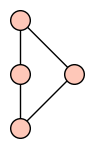

In [7]:
G1 = graph_theta_simple_L(2,4234123121)

print(convert_to_graded_char(G1) == M(s2,convert_from_123(4234123121)))

print_nice(G1)

True
-2: 4234123121
-1: 23412342312, 423412321, 42341234121, 423423121, 43423412321
0: 4234123121, 4234123121, 4234123421, 42343121, 434234123421, 4342343121
1: 23412342312, 423412321, 42341234121, 423423121, 43423412321
2: 4234123121


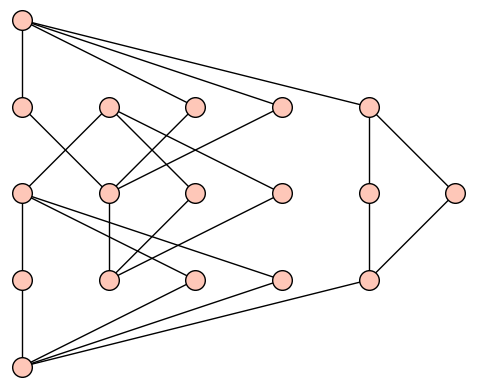

In [8]:
G2 = graph_theta(3,G1)

print(convert_to_graded_char(G2) == theta(s3,M(s2,convert_from_123(4234123121))))

print_nice(G2)

True
-3: 4234123121
-2: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
-1: 4234123121, 4234123121, 4234123121, 42341232, 4234123412, 4234123421, 423412342312, 42342312, 42343121, 4342341232, 434234123421, 43423412342312, 4342343121
0: 23412342312, 23412342312, 23412342312, 423412312, 423412312, 423412321, 423412321, 42341234121, 42341234121, 4234123412312, 4234123412312, 423412342, 423423121, 423423121, 4234312, 43423412321, 43423412321, 43423412342, 434234312
1: 4234123121, 4234123121, 4234123121, 42341232, 4234123412, 4234123421, 423412342312, 42342312, 42343121, 4342341232, 434234123421, 43423412342312, 4342343121
2: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
3: 4234123121


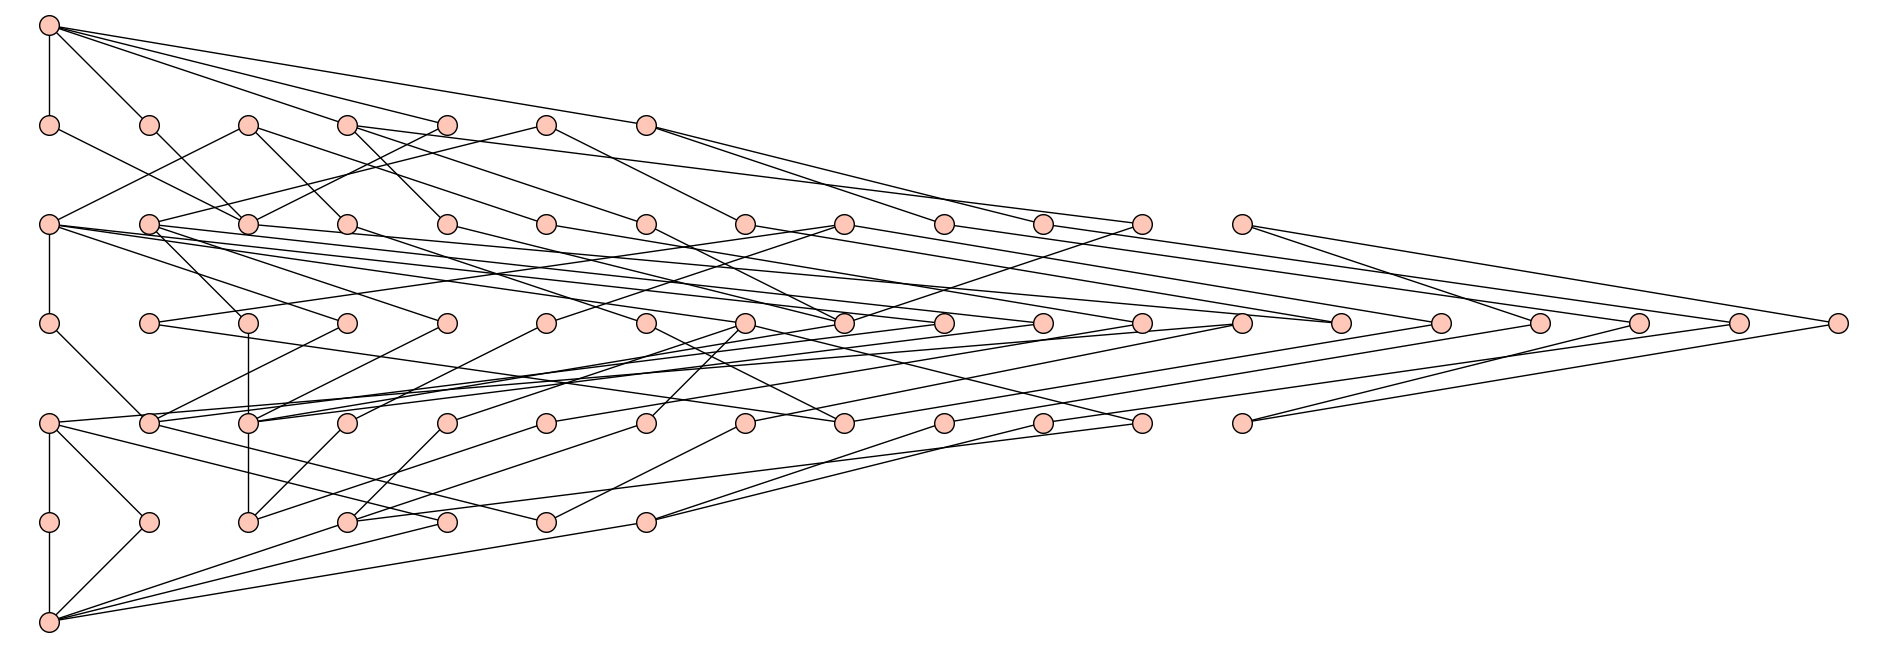

In [9]:
G3 = graph_theta(1,G2)

print(convert_to_graded_char(G3) == theta(s1,theta(s3,M(s2,convert_from_123(4234123121)))))

print_nice(G3)

True
-4: 4234123121
-3: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
-2: 2341234231, 42341231, 4234123121, 4234123121, 4234123121, 4234123412, 423412341231, 423412341231, 4234123421, 423412342312, 42342312, 42342321, 434234123421, 43423412342312
-1: 23412342312, 23412342312, 423412312, 423412312, 423412321, 423412321, 423412341, 42341234121, 42341234121, 42341234123, 4234123412312, 4234123412312, 42341234231, 4234231, 423423121, 423423121, 43423412321, 43423412321, 4342341234231
0: 2341234231, 42341231, 4234123121, 4234123121, 4234123121, 4234123412, 423412341231, 423412341231, 4234123421, 423412342312, 42342312, 42342321, 434234123421, 43423412342312
1: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
2: 4234123121


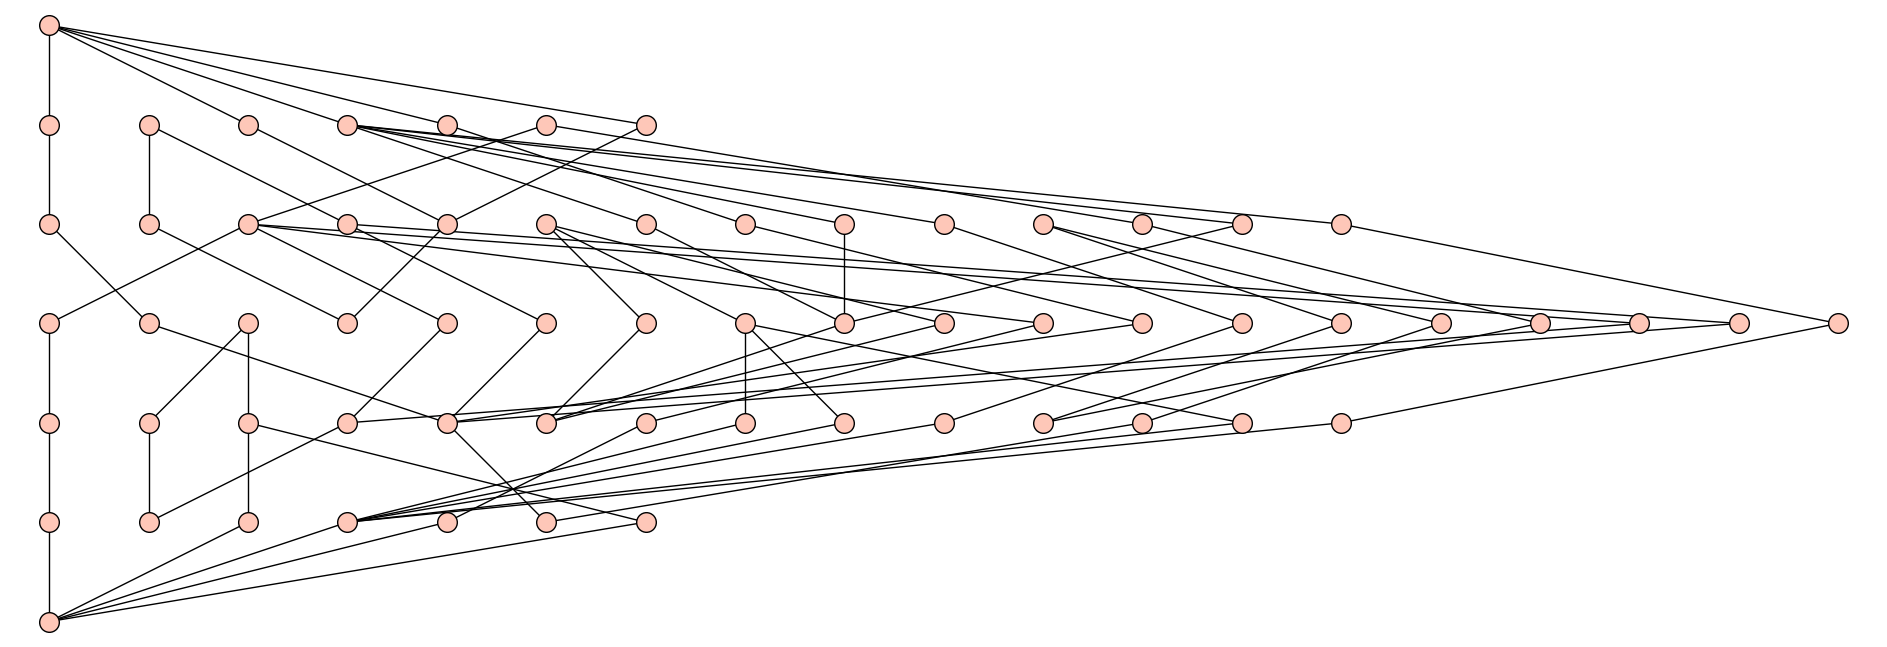

-2: 4234123121
-1: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
0: 2341234231, 42341231, 4234123121, 4234123121, 4234123121, 4234123412, 423412341231, 423412341231, 4234123421, 423412342312, 42342312, 42342321, 434234123421, 43423412342312
1: 23412342312, 23412342312, 423412312, 423412312, 423412321, 423412321, 423412341, 42341234121, 42341234121, 42341234123, 4234123412312, 4234123412312, 42341234231, 4234231, 423423121, 423423121, 43423412321, 43423412321, 4342341234231
2: 2341234231, 42341231, 4234123121, 4234123121, 4234123121, 4234123412, 423412341231, 423412341231, 4234123421, 423412342312, 42342312, 42342321, 434234123421, 43423412342312
3: 23412342312, 423412312, 423412321, 42341234121, 4234123412312, 423423121, 43423412321
4: 4234123121


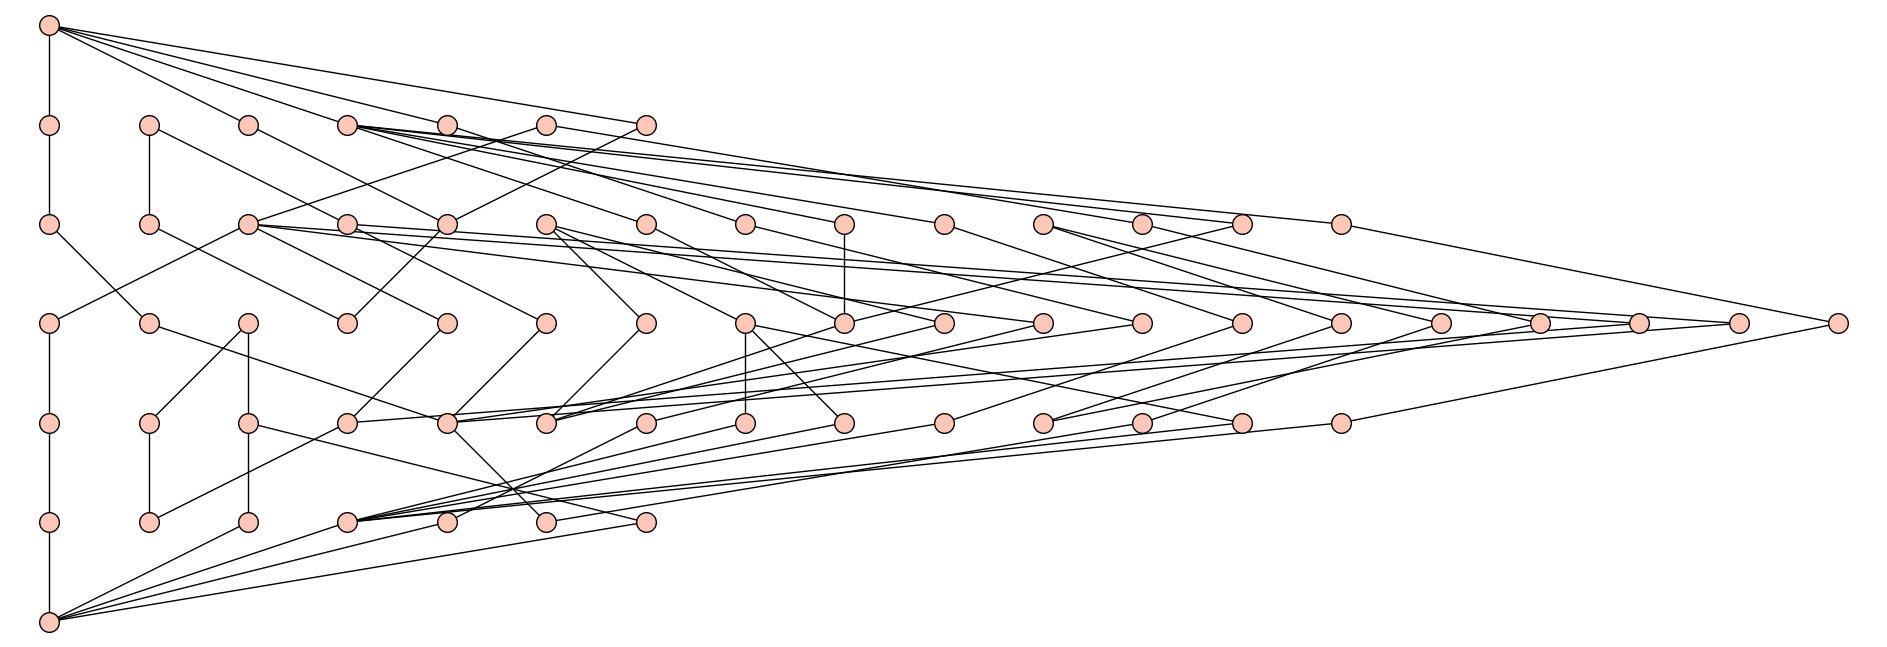

-2: 42343121
-1: 234123421, 23412342312, 423412321, 4234312, 4234321
0: 2341234231, 423431, 42343121, 42343121
1: 234123421, 23412342312, 423412321, 4234312, 4234321
2: 42343121


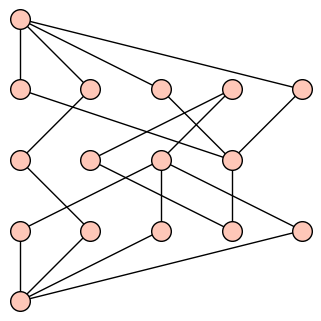

-2: 4342343121
-1: 43423412321, 434234312, 434234321
0: 43423431, 4342343121, 4342343121
1: 43423412321, 434234312, 434234321
2: 4342343121


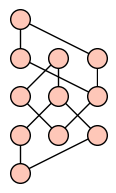

-2: 42341232
-1: 234123423, 4234123, 423412321, 42341234123
0: 42341232


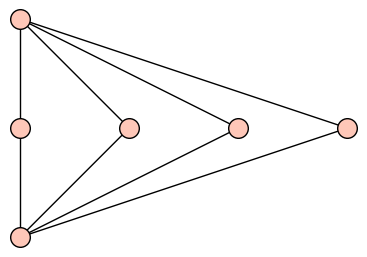

0: 42341232
1: 234123423, 4234123, 423412321, 42341234123
2: 42341232


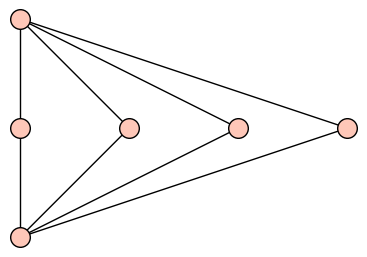

-2: 4342341232
-1: 42341234123, 434234123, 43423412321
0: 4342341232


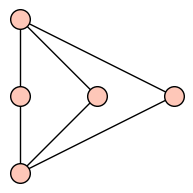

-1: 43423412342
0: 4342341234, 434234123421, 434234123423
1: 43423412342


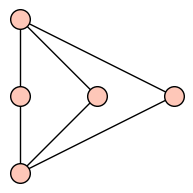

0: 4342341232
1: 42341234123, 434234123, 43423412321
2: 4342341232


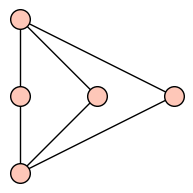

-1: 423412342
0: 42341234, 4234123421, 4234123423
1: 423412342


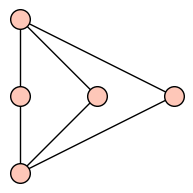

In [10]:
G4 = graph_theta(2,G3)

print(convert_to_graded_char(G4) == theta(s2,theta(s1,theta(s3,M(s2,convert_from_123(4234123121))))))

print_nice(G4)

In [428]:
a(s2*s3*s1*s2)

2

True
-1: 43431
0: 34123423, 34234123, 342341234123, 34234231, 3431, 41234231, 434123, 43412321, 4341234123, 434231
1: 43431


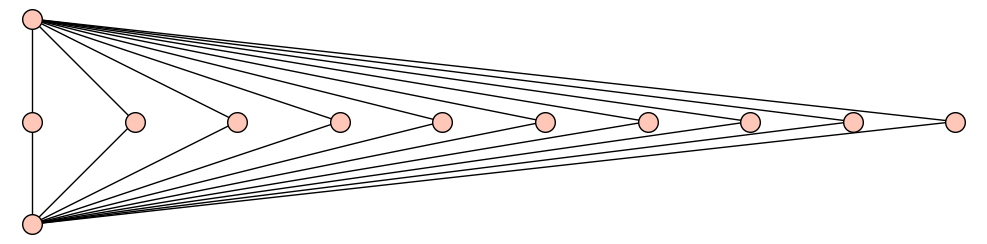

In [429]:
G1 = graph_theta_simple_L(4,43431)

print(convert_to_graded_char(G1) == M(s4,convert_from_123(43431)))

print_nice(G1)

True
-2: 43431
-1: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
0: 1234321, 341, 3412342, 3423412, 342341234, 34234123412, 3423421, 342342312, 34312, 34321, 4123421, 412342312, 43412, 4341234, 434123412, 434123421, 43421, 4342312, 4342341, 43431, 43431, 4343121
1: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
2: 43431


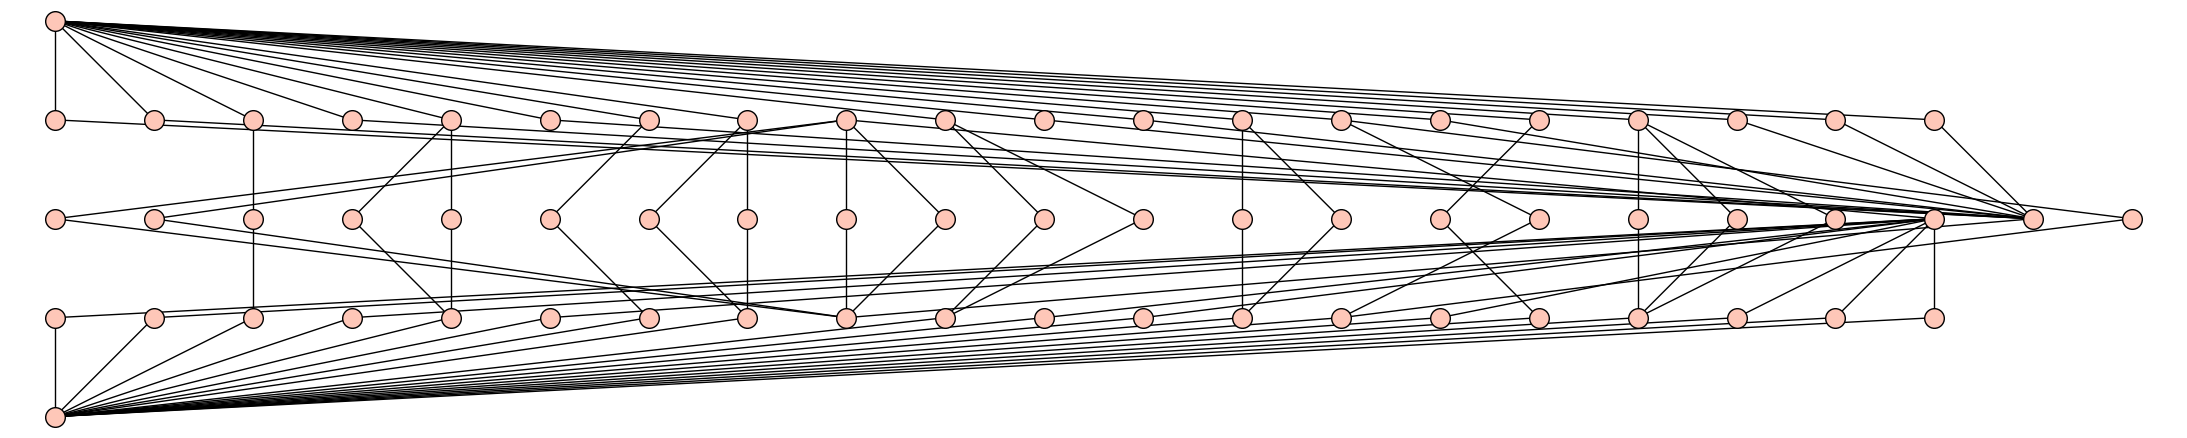

In [430]:
G2 = graph_theta(3,G1)

print(convert_to_graded_char(G2) == theta(s3,M(s4,convert_from_123(43431))))

print_nice(G2)

False
-3: 43431
-2: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
-1: 1234321, 34123, 3412321, 341234231, 34231, 342341231, 342342312, 34312, 34321, 412342312, 412342321, 431, 4341231, 4341232, 4342312, 4342321, 434234123, 43431, 43431
0: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
1: 43431


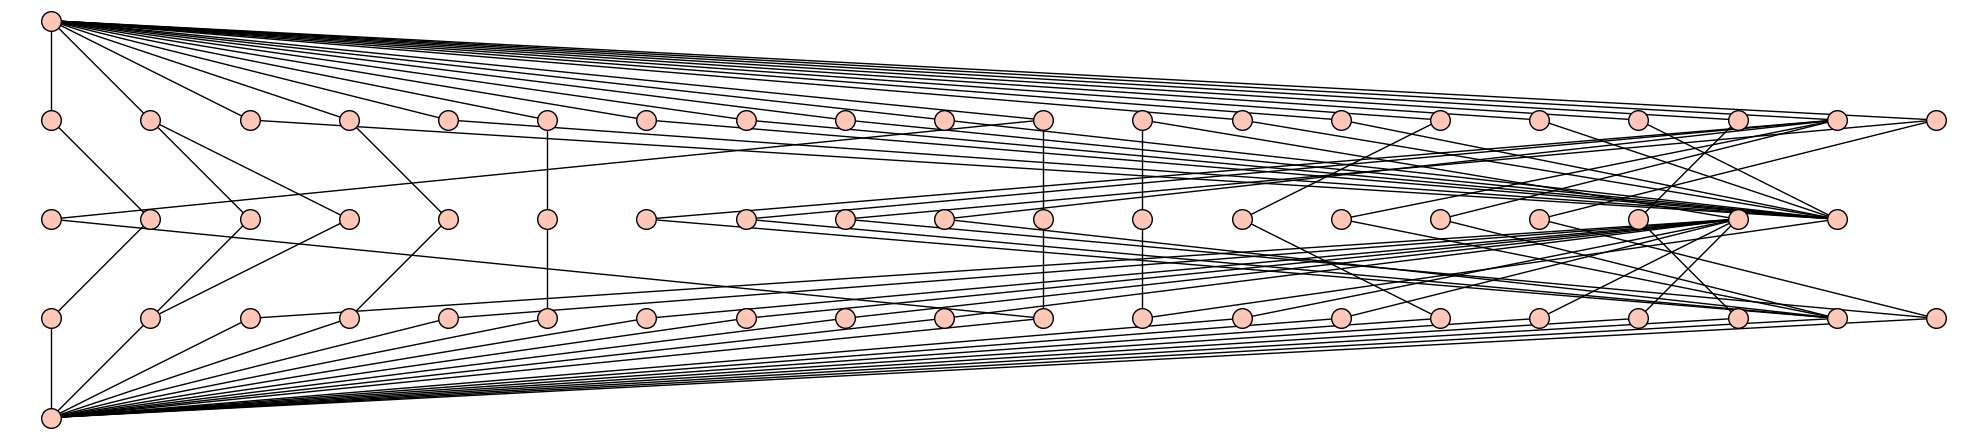

-1: 43431
0: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
1: 1234321, 34123, 3412321, 341234231, 34231, 342341231, 342342312, 34312, 34321, 412342312, 412342321, 431, 4341231, 4341232, 4342312, 4342321, 434234123, 43431, 43431
2: 341234, 34123421, 34123423, 342341, 34234123, 3423412341, 342341234123, 34234231, 3431, 41234231, 41234321, 4341, 434123, 43412321, 43412341, 4341234123, 434231, 4342341234, 434312, 434321
3: 43431


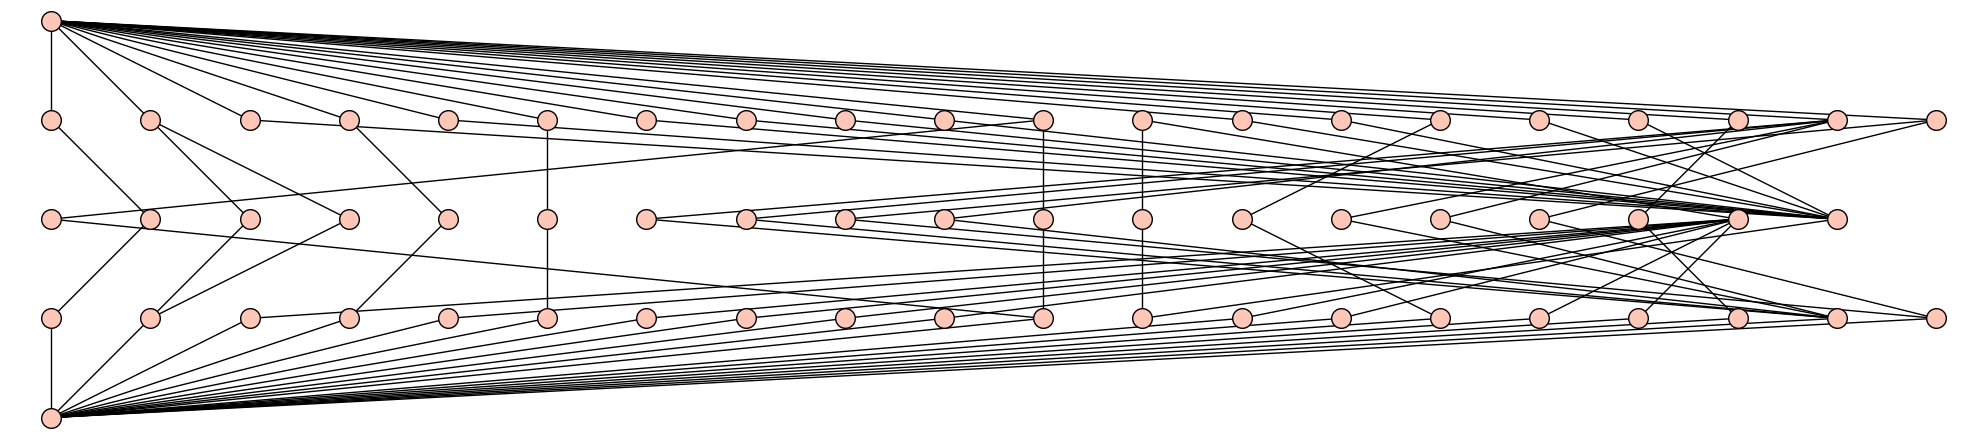

-1: 4343121
0: 3412342312, 343121, 4123423121, 43412321, 43423121
1: 4343121


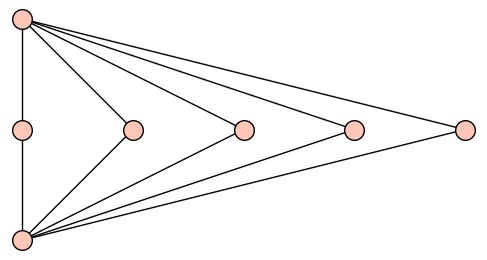

-1: 3412342
0: 341232, 34123423, 3412342312
1: 3412342


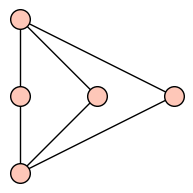

-1: 34234123412
0: 3423412312, 342341234123
1: 34234123412


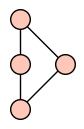

-1: 434123412
0: 43412312, 4341234123
1: 434123412


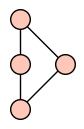

-1: 4123421
0: 412321, 41234231
1: 4123421


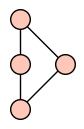

-1: 3423412
0: 342312, 34234123
1: 3423412


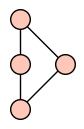

-1: 43412
0: 4312, 434123
1: 43412


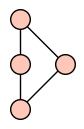

-1: 3423421
0: 342321, 34234231
1: 3423421


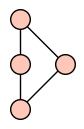

-1: 43421
0: 4321, 434231
1: 43421


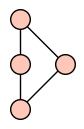

-1: 341
0: 31, 3431
1: 341


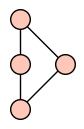

-1: 342341234
0: 34234123
1: 342341234


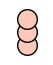

-1: 434123421
0: 43412321
1: 434123421


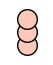

-1: 4341234
0: 434123
1: 4341234


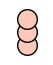

-1: 4342341
0: 434231
1: 4342341


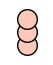

In [431]:
G3 = graph_theta(4,G2)

print(convert_to_graded_char(G4) == theta(s4,theta(s3,M(s4,convert_from_123(43431)))))

print_nice(G3)

In [433]:
print(multiply(s4,s4*s3))

434<0> + 4<0>



-1: 43431
0: 34123423, 34234123, 342341234123, 34234231, 3431, 41234231, 434123, 43412321, 4341234123, 434231
1: 43431


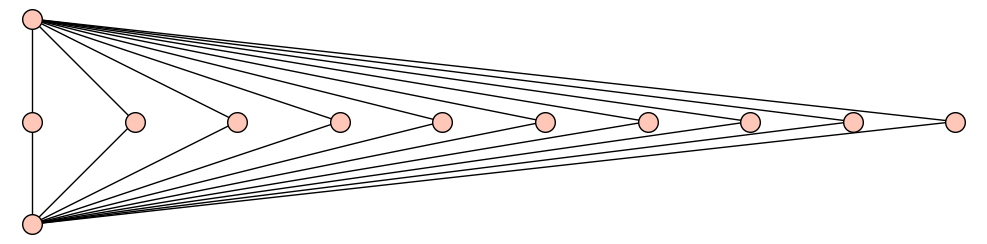

In [435]:
print_nice(graph_theta_simple_L(s4,convert_from_123(43431)))

In [ ]:


x=234

-1: 43432
0: 4342341234, 4343, 434321
1: 43432


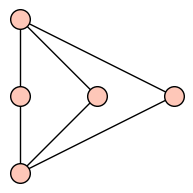

In [11]:
G = graph_theta_simple_L(2,43432)
print_nice(G)

-2: 4234123121
-1: 23412342312, 423412321, 42341234121, 423423121, 43423412321
0: 4234123121, 4234123121, 4234123421, 42343121, 434234123421, 4342343121
1: 23412342312, 423412321, 42341234121, 423423121, 43423412321
2: 4234123121


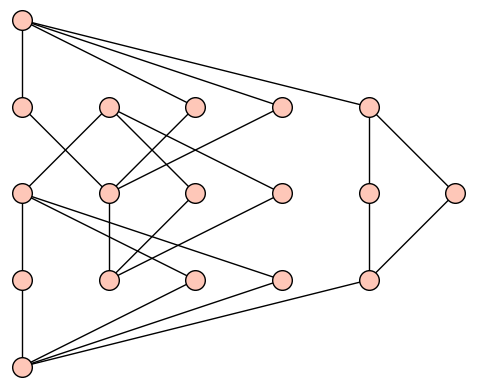

In [12]:
G2 = graph_theta(3,G1)
print_nice(G2)

-1: 42343121
0: 23412342312, 2343121, 423412321, 423423121
1: 42343121


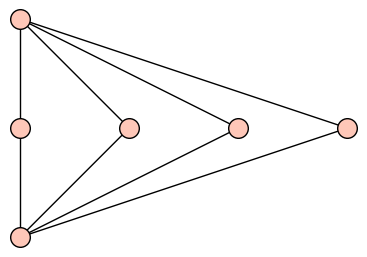

-2: 42341234121
-1: 4234123121, 423412341231
0: 42341234121


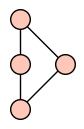

-1: 4342343121
0: 423423121, 43423412321
1: 4342343121


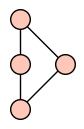

0: 42341234121
1: 4234123121, 423412341231
2: 42341234121


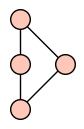

-1: 434234123421
0: 43423412321
1: 434234123421


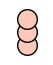

-1: 4234123421
0: 423412321
1: 4234123421


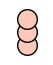

In [13]:
G3 = graph_theta(4,G2)
print_nice(G3)

In [14]:
a(s2*s3*s4)

1